# **Retention Effects of Level Gating in Cookie Cats**


## Introduction

### Goal

Cookie Cats is a popular mobile game. A key feature is a "gate" that requires players to wait or pay after reaching a certain level.

An A/B test was run to determine whether placing this gate at level 30 (control) or level 40 (treatment) leads to better player retention.

**Goal: To determine whether moving the gate from level 30 to level 40 has a positive impact on player retention.**


### Target Metric

The target metric is **retention**, measured in two ways:

- **1-day retention**: Whether a user returned to the game one day after installing it.
- **7-day retention**: Whether a user returned to the game seven days after installing it.

These binary metrics (Yes = 1, No = 0) allow us to assess short- and medium-term user engagement.


### Retention

**Retention** is a metric that tells us whether users return to the app or game after a certain amount of time.

Retention helps us understand how **engaging** and **sticky** the game is. If more users come back, it means the game is likely more enjoyable and effective at keeping their attention.

**1-Day Retention**
Measures short-term engagement.

Tells you if the game was interesting enough for players to come back quickly.

It's often used to spot major onboarding or early gameplay issues.

But: Some users need more time to get hooked, so 1-day retention can miss long-term effects.

**7-Day Retention**
Measures medium-term engagement.

Tells you whether users stick around after the first few sessions.

More useful for judging lasting interest and habit-building.

 ### Statistical Hypotheses

1. 1-Day Retention:

Null Hypothesis (H₀): **H₀: retention_1_gate30 = retention_1_gate40**

There is no difference in 1-day retention rates between users who faced the gate at level 30 and those who faced it at level 40.

Alternative Hypothesis (H₁): **H₀: retention_1_gate30 ≠ retention_1_gate40**

There is a difference in 1-day retention rates between the two groups.

2. 7-Day Retention:

Null Hypothesis (H₀): **H₀: retention_7_gate30 = retention_7_gate40**
There is no difference in 7-day retention rates between the two groups.

Alternative Hypothesis (H₁): **H₀: retention_7_gate30 ≠ retention_7_gate40**
There is a difference in 7-day retention rates between the two groups.


### Loading and exploring data

Importing libraries :

In [1]:
import pandas as pd
from scipy.stats import chisquare
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from scipy.stats import zscore
from scipy.stats import chi2_contingency
from scipy.stats import shapiro
from scipy.stats import levene
from CustomFunctionsCookieCats import (
    plot_game_rounds_boxplot,
    plot_1_day_retention_barplot,
    plot_7_day_retention_barplot,
    plot_retention_comparison_barplot,
    bootstrap_ci,
)

Checking shape and reading the database :

In [2]:
df = pd.read_csv("cookie_cats.csv")
print("Initial shape:", df.shape)
df.head()

Initial shape: (90189, 5)


,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


Check data shape, column names, nulls, and group sizes :

In [3]:
df.info()
df["version"].value_counts(normalize=True)
df[["retention_1", "retention_7"]].mean()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


retention_1    0.445210
retention_7    0.186065
dtype: float64

## Data cleaning and dealing with outliers :

Let's check the missing values :

In [4]:
print("Missing values:")
print(df.isnull().sum())

Missing values:
userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64


Removing any rows where retention values were missing (to avoid incorrect results) :

In [5]:
df = df.dropna(subset=["retention_1", "retention_7"])

print("After null drop:", df.shape)
print(df["sum_gamerounds"].describe())

After null drop: (90189, 5)
count    90189.000000
mean        51.872457
std        195.050858
min          0.000000
25%          5.000000
50%         16.000000
75%         51.000000
max      49854.000000
Name: sum_gamerounds, dtype: float64


Looked for outliers in sum_gamerounds (like people who played hundreds of rounds, which can skew your results). Before outlier removal :

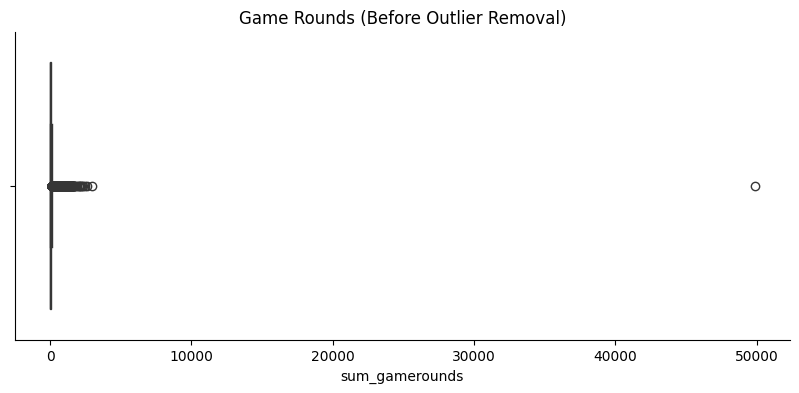

In [6]:
plot_game_rounds_boxplot(df, title="Game Rounds (Before Outlier Removal)")

Removingtop 1%, this keeps my data fair and clean — a few strange users shouldn’t affect the whole test. :


In [7]:
upper_limit = df["sum_gamerounds"].quantile(0.99)
df = df[df["sum_gamerounds"] <= upper_limit]

print("After outlier removal:", df.shape)

After outlier removal: (89291, 5)


Checking how it looks after cleaning :

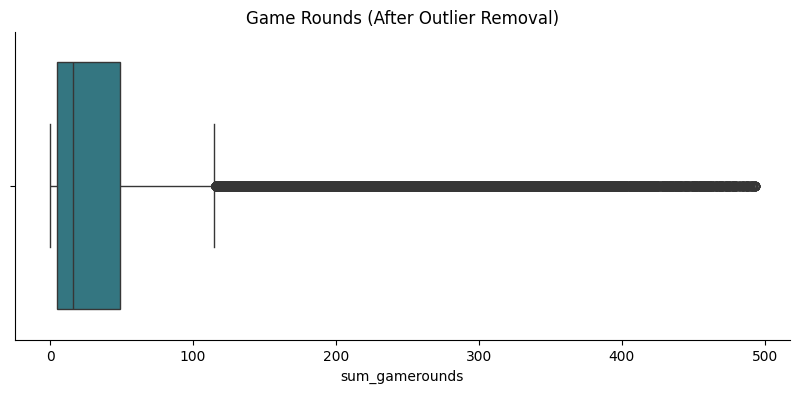

In [8]:
plot_game_rounds_boxplot(df, title="Game Rounds (After Outlier Removal)")

In [9]:
print("Group sizes:\n", df["version"].value_counts())
print("Retention rates:\n", df[["retention_1", "retention_7"]].mean())

Group sizes:
 version
gate_40    45037
gate_30    44254
Name: count, dtype: int64
Retention rates:
 retention_1    0.439888
retention_7    0.178327
dtype: float64


## SRM and filtering players who didn't reach gate 30

### Sample ratio mismatch (SRM) check before players filtering

The SRM check tells us whether the split between groups (gate_30 vs gate_40) was done fairly and randomly.
In an ideal A/B test, we expect the groups to be close to 50/50, unless intentionally designed otherwise.

In [10]:
observed = df["version"].value_counts().values
expected = [len(df) / 2, len(df) / 2]

chi2, p_srm = chisquare(f_obs=observed, f_exp=expected)
print(f"SRM check: chi2 = {chi2:.2f}, p = {p_srm:.4f}")

SRM check: chi2 = 6.87, p = 0.0088


The p-value is less than 0.05, which means this result is statistically significant.

That suggests a Sample Ratio Mismatch occurred:
The actual split between gate_30 and gate_40 users deviated more than expected by chance.

In [11]:
observed = df["version"].value_counts().values
expected = [len(df) / 2, len(df) / 2]

chi2, p_srm = chisquare(f_obs=observed, f_exp=expected)
print(f"SRM check: chi2 = {chi2:.2f}, p = {p_srm:.4f}")

SRM check: chi2 = 6.87, p = 0.0088


###  Filtering for Players Who Reached the Gate


To ensure we’re only analyzing users affected by the gate, we filter out those who didn’t reach level 30. 
Since we don’t have exact level data, we assume that completing at least **30 game rounds** corresponds to reaching level 30.

This step makes our analysis more relevant by focusing only on users who could have interacted with the gate at level 30 or 40.

In [12]:
df = df[df["sum_gamerounds"] >= 30]
print("After filtering players who likely reached level 30:", df.shape)

After filtering players who likely reached level 30: (32371, 5)


### Sample ratio mismatch (SRM) check after players filtering

I am testing if both groups had about the same number of users using a Chi-square test. If one group had way more users, the test might be unfair.

In [13]:
observed = df["version"].value_counts().values
expected = [len(df) / 2, len(df) / 2]

chi2, p_srm = chisquare(f_obs=observed, f_exp=expected)
print(f"SRM check: chi2 = {chi2:.2f}, p = {p_srm:.4f}")

SRM check: chi2 = 0.07, p = 0.7854


**Conclusion on filtering players and SRM checks:**

Although the initial SRM check showed a statistically significant imbalance (Chi² = 6.87, p = 0.0088), we later **filtered the dataset** to include only users who had the opportunity to reach level 30. This resolved the mismatch, as confirmed by a post-filter SRM check (Chi² = 0.07, p = 0.7854).

However, since SRM was present in the original dataset, it's possible that **hidden biases or imbalances** still exist. To ensure robustness, I will apply **bootstrapping** to estimate confidence intervals for the treatment effect later on in the project.



## 1-Day Retention Analysis

### Separating groups and testing for normality

I will now separate the users into two groups based on which version of the game they received:

- `group_A` contains the 1-day retention data for users who encountered the gate at **level 30** (control group).
- `group_B` contains the 1-day retention data for users who encountered the gate at **level 40** (test group).

This allows me to directly compare the retention rates between the two groups and run statistical tests.

In [14]:
group_A_1 = df[df["version"] == "gate_30"]["retention_1"]
group_B_1 = df[df["version"] == "gate_40"]["retention_1"]

To check whether 1-day retention values follow a normal distribution, we applied the Shapiro-Wilk test to both groups:

In [ ]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message=".*scipy.stats.shapiro.*")

    stat_30, pval_30 = shapiro(group_A_1)
    stat_40, pval_40 = shapiro(group_B_1)

print(
    f"Shapiro-Wilk test (gate_30): statistic = {stat_30:.4f}, p-value = {pval_30:.2e}"
)
print(
    f"Shapiro-Wilk test (gate_40): statistic = {stat_40:.4f}, p-value = {pval_40:.2e}"
)

Shapiro-Wilk test (gate_30): statistic = 0.4939, p-value = 7.70e-111
Shapiro-Wilk test (gate_40): statistic = 0.4932, p-value = 8.59e-111



- **Gate 30** statistic = 0.4939, p-value = 7.70e-111  
- **Gate 40** statistic = 0.4932, p-value = 8.59e-111  

These extremely low p-values indicate that **1-day retention data is not normally distributed**, which is expected since retention is a **binary variable** (0 or 1). Additionally, due to the large sample size (N > 5000), the p-values should be interpreted with caution.

**Conclusion:** Since the assumption of normality is violated, we rely on **non-parametric methods** (like the Chi-square test and bootstrapping) instead of parametric tests such as the t-test.

### Chi-square test 

Chi-square test, this helps me understand if the difference in retention between the two groups is real or just due to random chance :

In [16]:
contingency = pd.crosstab(df["version"], df["retention_1"])
chi2, p, dof, expected = chi2_contingency(contingency)
print("Chi-square test for 1-day retention:")
print(f"χ² = {chi2:.2f}, p = {p:.4f}")

Chi-square test for 1-day retention:
χ² = 0.02, p = 0.9007


This test supports the null(H0) hypothesis. The p-value (0.9007) is much greater than 0.05.

### Treatment effect

The treatment effect is the difference in the metric between the treatment and control groups.

Treatment effect :

In [17]:
retention_A_1 = group_A_1.mean()
retention_B_1 = group_B_1.mean()
treatment_effect_1 = retention_B_1 - retention_A_1

print(f"Gate 30 1-day retention: {retention_A_1:.4f} ({retention_A_1:.2%})")
print(f"Gate 40 1-day retention: {retention_B_1:.4f} ({retention_B_1:.2%})")
print(
    f"Treatment effect (Gate 40 - Gate 30): {treatment_effect_1:.4f} ({treatment_effect_1:.2%})"
)

Gate 30 1-day retention: 0.7963 (79.63%)
Gate 40 1-day retention: 0.7969 (79.69%)
Treatment effect (Gate 40 - Gate 30): 0.0006 (0.06%)


The effect size is tiny, but Gate 40 has slightly higher 1-day retention than Gate 30.

### Bootstrap confidence interval 

Bootstrapping:
- Makes no assumptions about the shape of the data
- Is robust to mild irregularities or imbalances
- Helps validate the results of parametric tests

This approach will allow me to better quantify uncertainty and validate the reliability of my findings, especially in light of the initial imbalance.

Let's use bootstrapping to simulate thousands of “what ifs” based on the data. This will give me a range of possible values for the difference in retention.

In [18]:
ci = bootstrap_ci(group_A_1.values, group_B_1.values)
print("Bootstrap 95% CI for treatment effect:", ci)

Bootstrap 95% CI for treatment effect: [-0.00829794  0.00964227]


The 95% confidence interval for the difference in 1-day retention between the groups is approximately **[−0.82%, +0.95%]**.

Since this range **includes 0**, we cannot be confident that there is a real effect — the observed difference in retention could be due to random chance.

This confidence interval supports the null hypothesis (H0).

### 1-Day Retention Rate by Gate Version

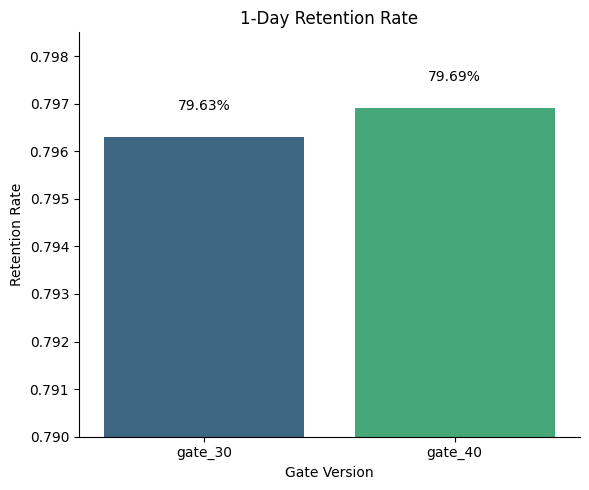

In [19]:
plot_1_day_retention_barplot(df)


This bar chart compares the 1-day retention rates of users who reached at least level 30.  

Retention is slightly higher in the Gate 40 group (79.69%) compared to Gate 30 (79.63%),  
but the difference is **very small** and likely due to chance.

### Conclusion and recommendation on 1 day retention

The difference in 1-day retention between `gate_30` and `gate_40` is **+0.0006** (+0.06 percentage points), meaning retention **slightly increased** when the gate was moved to level 40 — but the change is extremely small.

- **Chi-square p-value:** 0.9007  
- **Bootstrap 95% Confidence Interval:** [−0.82%, +0.95%]

Since the **p-value is very high** and the **confidence interval includes 0**, the difference is **not statistically significant**.


**Recommendation:**
Keep the gate at **level 30**.

The observed change is negligible and not enough to justify altering the game flow.

## 7-Day Retention Analysis

### Separating groups and testing for normality

Separating groups :

In [20]:
group_A_7 = df[df["version"] == "gate_30"]["retention_7"]
group_B_7 = df[df["version"] == "gate_40"]["retention_7"]

Testing for normality :

In [21]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning)

    stat_30_7, pval_30_7 = shapiro(group_A_7)
    stat_40_7, pval_40_7 = shapiro(group_B_7)

print(
    f"Shapiro-Wilk test (gate_30, 7-day): statistic = {stat_30_7:.4f}, p-value = {pval_30_7:.2e}"
)
print(
    f"Shapiro-Wilk test (gate_40, 7-day): statistic = {stat_40_7:.4f}, p-value = {pval_40_7:.2e}"
)

Shapiro-Wilk test (gate_30, 7-day): statistic = 0.6283, p-value = 7.35e-103
Shapiro-Wilk test (gate_40, 7-day): statistic = 0.6261, p-value = 6.21e-103


**Conclusions:**
- **Gate 30** - statistic = 0.6283, p-value = 7.35e-103  
- **Gate 40** - statistic = 0.6261, p-value = 6.21e-103  

These extremely low p-values indicate that the **7-day retention data is not normally distributed**, which is expected since retention is a **binary variable** (0 or 1). This supports our choice to rely on **non-parametric methods**, such as the Chi-square test and bootstrapping.

Normality is violated. I will continue using non-parametric tests for statistical analysis.

### Chi-square test

Chi-square test results :

In [22]:
contingency_7 = pd.crosstab(df["version"], df["retention_7"])
chi2_7, p_value_7, _, _ = chi2_contingency(contingency_7)

The p-value (0.0012) is below 0.05, meaning the difference in 7-day retention between the two gate versions is statistically significant — the gate location does influence long-term engagement.

This test rejects H0 and supports H1 hypothesis.

### Treatment effect

I will calculate the average 7-day retention for each group and the treatment effect, which is the difference between them :

In [23]:
retention_A_7 = group_A_7.mean()
retention_B_7 = group_B_7.mean()
treatment_effect_7 = retention_B_7 - retention_A_7

print(f"Gate 30 7-day retention: {retention_A_7:.4f} ({retention_A_7:.2%})")
print(f"Gate 40 7-day retention: {retention_B_7:.4f} ({retention_B_7:.2%})")
print(
    f"Treatment effect (Gate 40 - Gate 30): {treatment_effect_7:.4f} ({treatment_effect_7:.2%})"
)

Gate 30 7-day retention: 0.4247 (42.47%)
Gate 40 7-day retention: 0.4152 (41.52%)
Treatment effect (Gate 40 - Gate 30): -0.0095 (-0.95%)


Gate 40 led to a slightly lower 7-day retention rate (−0.95%), suggesting it may reduce long-term player engagement.

### Bootstrap confidence interval 

In [24]:
ci_7 = bootstrap_ci(group_A_7.values, group_B_7.values)
print("Bootstrap 95% CI for 7-day treatment effect:", ci_7)

Bootstrap 95% CI for 7-day treatment effect: [-0.0202952   0.00108234]


**Bootstrap 95% CI**: [-2.04%, +0.13%]

Since this confidence interval **includes 0**, we cannot be 95% confident that the observed difference is real.  
While the treatment effect suggests lower 7-day retention with gate_40, the result is **not statistically significant** based on this interval alone.

I use the following line to estimate the **95% confidence interval** for the difference in 7-day retention between the two groups:


In [25]:
ci_7 = bootstrap_ci(group_A_7.values, group_B_7.values)

### 7-Day Retention Rate by Gate Version

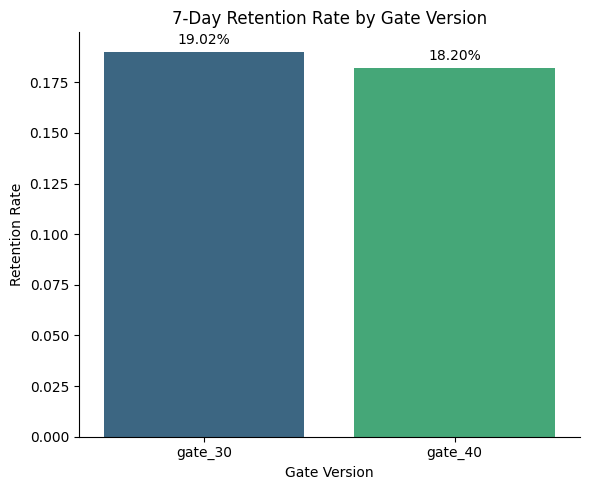

In [26]:
retention_7_clean_df = pd.DataFrame(
    {
        "version": ["gate_30", "gate_40"],
        "retention_7": [0.1902, 0.1820],
    }
)
plot_7_day_retention_barplot(retention_7_clean_df)

Chart compares the 7-day retention of players who reached at least level 30.  
While both groups show similar engagement, retention is slightly higher in the Gate 30 group, suggesting better long-term performance with the gate placed earlier.

### Conclusion and recommendation on 7 day retention

**Conclusion**

The 7-day retention rate was:

- **Gate 30:** 19.02%  
- **Gate 40:** 18.20%  
- **Treatment Effect:** −0.82 percentage points

**Bootstrap 95% Confidence Interval:** [−2.04%, +0.13%]  
This interval includes 0, meaning the difference is **not statistically significant** at the 95% confidence level.  
The drop in retention suggests a possible negative effect, but we **cannot be fully confident** it's not due to chance.


**Recommendation**

Keep the gate at level 30.

There is a small decrease in long-term retention when moving the gate to level 40, but the difference is **not statistically significant**.  
Given the **potential risk** and **lack of clear benefit**, it’s safer to **keep the gate at level 30**.

## Comparison of 1-Day and 7-Day Retentions

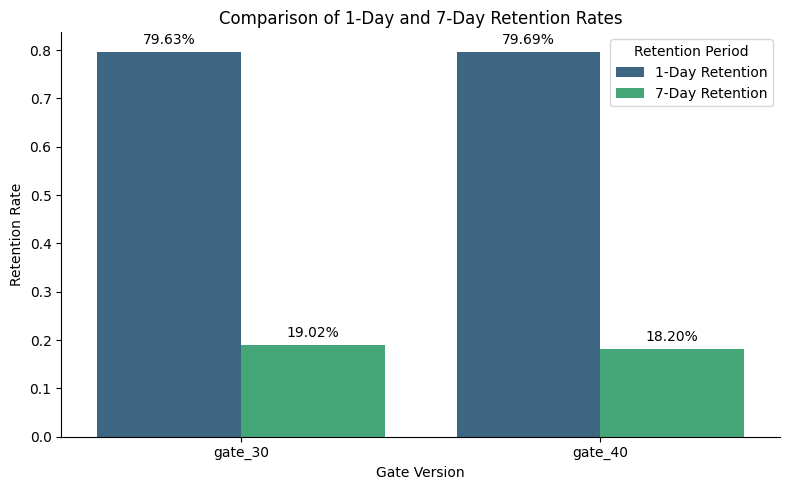

In [27]:
comparison_df = pd.DataFrame(
    {
        "version": ["gate_30", "gate_40"],
        "retention_1": [0.7963, 0.7969],
        "retention_7": [0.1902, 0.1820],
    }
)
plot_retention_comparison_barplot(comparison_df)

- For **1-day retention** (in blue), both gate versions show **very high and nearly identical retention rates** (~79.6%). There is no meaningful difference in short-term engagement.

- For **7-day retention** (in red), the `gate_30` group performs **noticeably better** than `gate_40`, with a difference of **−0.82 percentage points**. Although this is not statistically significant, it suggests a potential negative impact when the gate is moved later.

This visual supports the idea that **moving the gate to level 40 does not improve engagement** and may slightly reduce long-term player retention.

**Conclusion:**

The gate at **level 30** performs slightly better overall.  
Given the lack of short-term gains and the risk of long-term decline, the gate should be **kept at level 30**.

## Final Conclusion and Recommendation

### Goal and hypotheses

Goal was to determine if moving the gate from level 30 to level 40 improves player retention.

Null Hypothesis (H0): There is no difference in retention between gate_30 and gate_40

Alternative Hypothesis (H1): There is a difference in retention between gate_30 and gate_40

### 1-Day retention conclusion

Gate 30: 79.63%

Gate 40: 79.69%

Difference: +0.06 pp

Chi-square p-value: 0.9007

Bootstrap CI: [−0.82%, +0.95%]

Conclusion:
No statistically significant difference. We fail to reject H0.
Gate 40 does not improve short-term retention.

### 7-Day retention conclusion

Gate 30: 19.02%

Gate 40: 18.20%

Difference: −0.82 pp

Chi-square p-value: 0.0012

Bootstrap CI: [−2.04%, +0.13%]

Conclusion:
Statistically significant p-value, so we reject H0.
However, the CI includes 0, so the result isn't robust.
Gate 40 may reduce long-term retention.

### Final recommendation

Keep the gate at **level 30**.

There is no meaningful improvement in short-term retention,  
and there is a potential (though not statistically certain) decrease in long-term retention when moving the gate to level 40.